In [1]:
import numpy as np


def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N


def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

In [2]:
f_w0 = -0.3
f_w1 =  0.5


def f(X, noise_variance):
    '''Linear function plus noise'''
    return f_w0 + f_w1 * X + noise(X.shape, noise_variance)


def g(X, noise_variance):
    '''Sinus function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)


def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

In [3]:
def identity_basis_function(x):
    return x


def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, degree):
    return x ** degree


def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

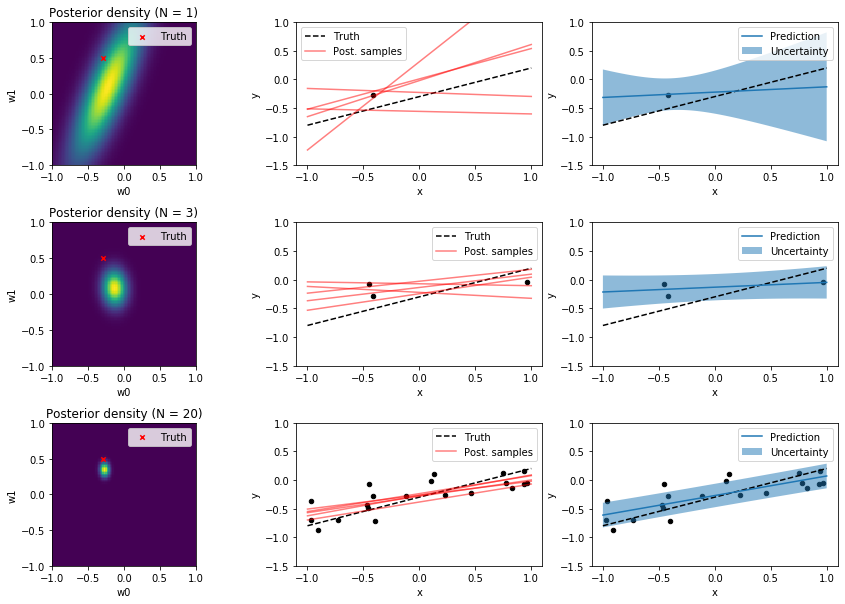

In [5]:
from bayesian_linear_regression_util import *

import matplotlib.pyplot as plt
%matplotlib inline

# Training dataset sizes
N_list = [1, 3, 20]

beta = 25.0
alpha = 2.0

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1) * 2 - 1

# Training target values
t = f(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = f(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, identity_basis_function)

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, identity_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 3, i * 3 + 1)
    plot_posterior(m_N, S_N, f_w0, f_w1)
    plt.title(f'Posterior density (N = {N})')
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 3)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.5, 1.0)
    plt.legend()

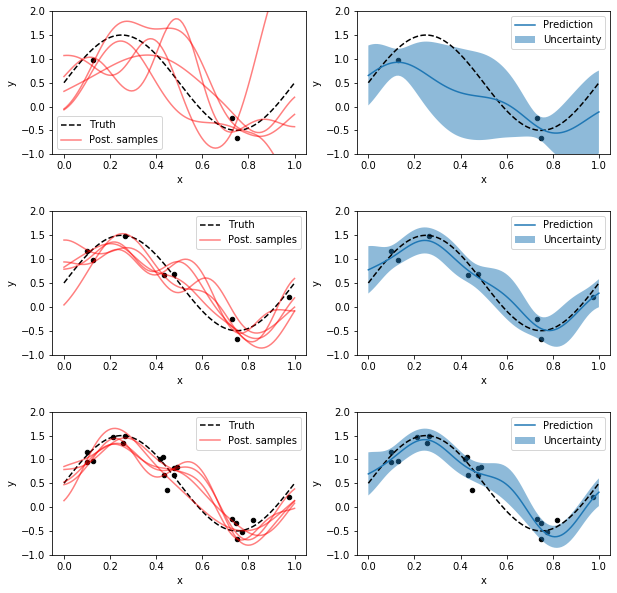

In [6]:
N_list = [3, 8, 20]

beta = 25.0
alpha = 2.0

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1)

# Training target values
t = g(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = g(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 9))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 9))

    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 2, i * 2 + 1)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.0, 2.0)
    plt.legend()
    
    plt.subplot(len(N_list), 2, i * 2 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.0, 2.0)
    plt.legend()


In [7]:
def log_marginal_likelihood(Phi, t, alpha, beta):
    """Computes the log of the marginal likelihood."""
    N, M = Phi.shape

    m_N, _, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)
    
    E_D = beta * np.sum((t - Phi.dot(m_N)) ** 2)
    E_W = alpha * np.sum(m_N ** 2)
    
    score = M * np.log(alpha) + \
            N * np.log(beta) - \
            E_D - \
            E_W - \
            np.log(np.linalg.det(S_N_inv)) - \
            N * np.log(2 * np.pi)

    return 0.5 * score

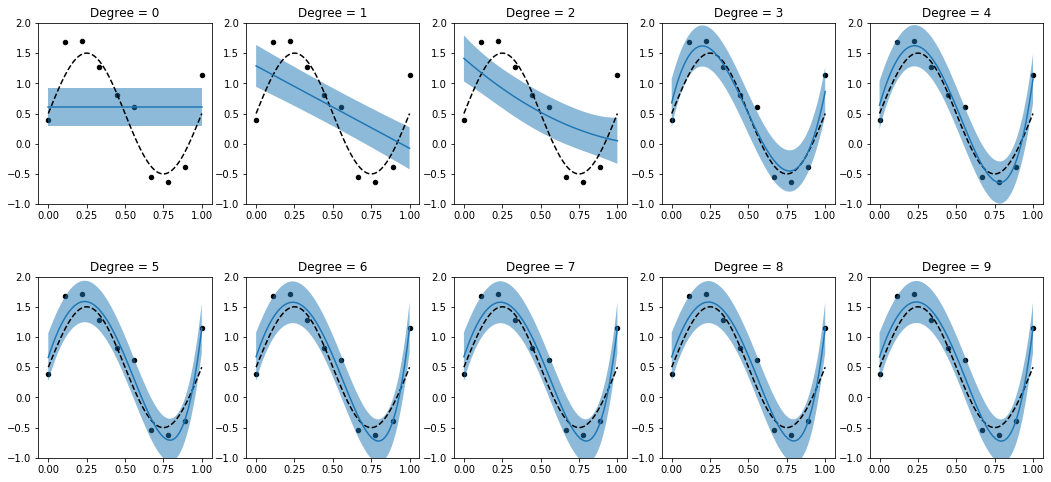

In [8]:
N = 10

beta = 1 / (0.3 ** 2)
alpha = 0.005

degree = 9
degrees = range(degree + 1)

X = np.linspace(0, 1, N).reshape(-1, 1)
t = g(X, noise_variance=1/beta)

Phi = expand(X, bf=polynomial_basis_function, bf_args=degrees[1:])
Phi_test = expand(X_test, bf=polynomial_basis_function, bf_args=degrees[1:])

plt.figure(figsize=(18, 8))
plt.subplots_adjust(hspace=0.4)

for d in degrees:
    up = d + 1
    m_N, S_N = posterior(Phi[:,:up], t, alpha, beta)
    y, y_var = posterior_predictive(Phi_test[:,:up], m_N, S_N, beta)

    plt.subplot(2, 5, up)
    plot_data(X, t)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var), y_label=None, std_label=None, plot_xy_labels=False)
    plt.title(f'Degree = {d}')
    plt.ylim(-1.0, 2.0)

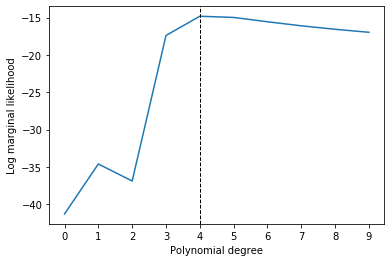

In [9]:
mlls = []

for d in degrees:
    mll = log_marginal_likelihood(Phi[:,:d+1], t, alpha=alpha, beta=beta)
    mlls.append(mll)

degree_max = np.argmax(mlls)
    
plt.plot(degrees, mlls)
plt.axvline(x=degree_max, ls='--', c='k', lw=1)
plt.xticks(range(0, 10))
plt.xlabel('Polynomial degree')
plt.ylabel('Log marginal likelihood');

In [10]:
def fit(Phi, t, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5, verbose=False):
    """
    Jointly infers the posterior sufficient statistics and optimal values 
    for alpha and beta by maximizing the log marginal likelihood.
    
    Args:
        Phi: Design matrix (N x M).
        t: Target value array (N x 1).
        alpha_0: Initial value for alpha.
        beta_0: Initial value for beta.
        max_iter: Maximum number of iterations.
        rtol: Convergence criterion.
        
    Returns:
        alpha, beta, posterior mean, posterior covariance.
    """
    
    N, M = Phi.shape

    eigenvalues_0 = np.linalg.eigvalsh(Phi.T.dot(Phi))

    beta = beta_0
    alpha = alpha_0

    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha

        eigenvalues = eigenvalues_0 * beta

        m_N, S_N, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)

        gamma = np.sum(eigenvalues / (eigenvalues + alpha))
        alpha = gamma / np.sum(m_N ** 2)

        beta_inv = 1 / (N - gamma) * np.sum((t - Phi.dot(m_N)) ** 2)
        beta = 1 / beta_inv

        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(beta_prev, beta, rtol=rtol):
            if verbose:
                print(f'Convergence after {i + 1} iterations.')
            return alpha, beta, m_N, S_N

    if verbose:
        print(f'Stopped after {max_iter} iterations.')
    return alpha, beta, m_N, S_N

In [11]:
N = 30

degree = 4

X = np.linspace(0, 1, N).reshape(-1, 1)
t = g(X, noise_variance=0.3 ** 2)

Phi = expand(X, bf=polynomial_basis_function, bf_args=range(1, degree + 1))

alpha, beta, m_N, S_N = fit(Phi, t, rtol=1e-5, verbose=True)


Convergence after 23 iterations.


In [12]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge(fit_intercept=False, tol=1e-5, verbose=True)
br.fit(Phi, t.ravel());

Convergence after  24  iterations


In [13]:
print_comparison('Alpha', alpha, br.lambda_)

Alpha
-----
np: 0.010161431850888603
br: 0.010161418281211382



In [14]:
print_comparison('Beta', beta, br.alpha_)

Beta
----
np: 7.3023385389381525
br: 7.3023370443373015



In [15]:
print_comparison('Weights', m_N.ravel(), br.coef_)

Weights
-------
np: [  0.63972333   6.57194616 -15.59244933  -1.02192328  10.12676404]
br: [  0.63972245   6.57195662 -15.59247511  -1.02190519  10.12676268]



In [16]:
# Test values at x = 0.3 and x = 0.7 
X_test = np.array([[0.3], [0.7]])

# Design matrix of test values
Phi_test = expand(X_test, bf=polynomial_basis_function, bf_args=range(1, degree + 1))

In [17]:
y_np_mean, y_np_var = posterior_predictive(Phi_test, m_N, S_N, beta)
y_br_mean, y_br_std = br.predict(Phi_test, return_std=True)

print_comparison('Prediction mean', y_np_mean.ravel(), y_br_mean)
print_comparison('Prediction std', np.sqrt(y_np_var), y_br_std)

Prediction mean
---------------
np: [ 1.2624216  -0.31929816]
br: [ 1.26242202 -0.31929848]

Prediction std
--------------
np: [0.38744735 0.38886186]
br: [0.38744738 0.38886189]

